#  1. Data Loading and Exploration

In [14]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   -------------------------------------- - 286.7/294.9 kB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import joblib

# Load the datasets
rides_df = pd.read_csv('cab_rides.csv')
weather_df = pd.read_csv('weather.csv')

# Display the first few rows of each dataset
rides_df_head = rides_df.head()
weather_df_head = weather_df.head()

In [3]:
rides_df_head, weather_df_head

(   distance cab_type     time_stamp    destination            source  price  \
 0      0.44     Lyft  1544952607890  North Station  Haymarket Square    5.0   
 1      0.44     Lyft  1543284023677  North Station  Haymarket Square   11.0   
 2      0.44     Lyft  1543366822198  North Station  Haymarket Square    7.0   
 3      0.44     Lyft  1543553582749  North Station  Haymarket Square   26.0   
 4      0.44     Lyft  1543463360223  North Station  Haymarket Square    9.0   
 
    surge_multiplier                                    id    product_id  \
 0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line   
 1               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier   
 2               1.0  981a3613-77af-4620-a42a-0c0866077d1e          lyft   
 3               1.0  c2d88af2-d278-4bfd-a8d0-29ca77cc5512   lyft_luxsuv   
 4               1.0  e0126e1f-8ca9-4f2e-82b3-50505a09db9a     lyft_plus   
 
            name  
 0        Shared  
 1           Lux  
 2 

In [4]:
# Display the summary information of each dataset
rides_info = rides_df.info()
weather_info = weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276

In [5]:
# Display the number of missing values in each dataset
rides_na_sum = rides_df.isna().sum()
weather_na_sum = weather_df.isna().sum()

In [6]:
rides_na_sum, weather_na_sum

(distance                0
 cab_type                0
 time_stamp              0
 destination             0
 source                  0
 price               55095
 surge_multiplier        0
 id                      0
 product_id              0
 name                    0
 dtype: int64,
 temp             0
 location         0
 clouds           0
 pressure         0
 rain          5382
 time_stamp       0
 humidity         0
 wind             0
 dtype: int64)

# 2: Data Preprocessing and Merging

In [7]:
# Handling missing values
ride_df = rides_df.dropna(axis=0).reset_index(drop=True)
weather_df['rain'] = weather_df['rain'].fillna(0)

In [8]:
# Grouping weather data by location and calculating the mean for each location
avr_weather_df = weather_df.groupby('location').mean().reset_index(drop=False)
avr_weather_df = avr_weather_df.drop('time_stamp', axis=1)

In [9]:
# Renaming columns of the grouped weather data to prepare for merging
source_weather_df = avr_weather_df.rename(
    columns={
        'location': 'source',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'rain': 'source_rain',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)
destination_weather_df = avr_weather_df.rename(
    columns={
        'location': 'destination',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'rain': 'destination_rain',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'
    }
)

In [10]:
# Merging datasets based on 'source' and 'destination' columns
data = ride_df\
    .merge(source_weather_df, on='source')\
    .merge(destination_weather_df, on='destination')

data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755


# 3: Data Visualization

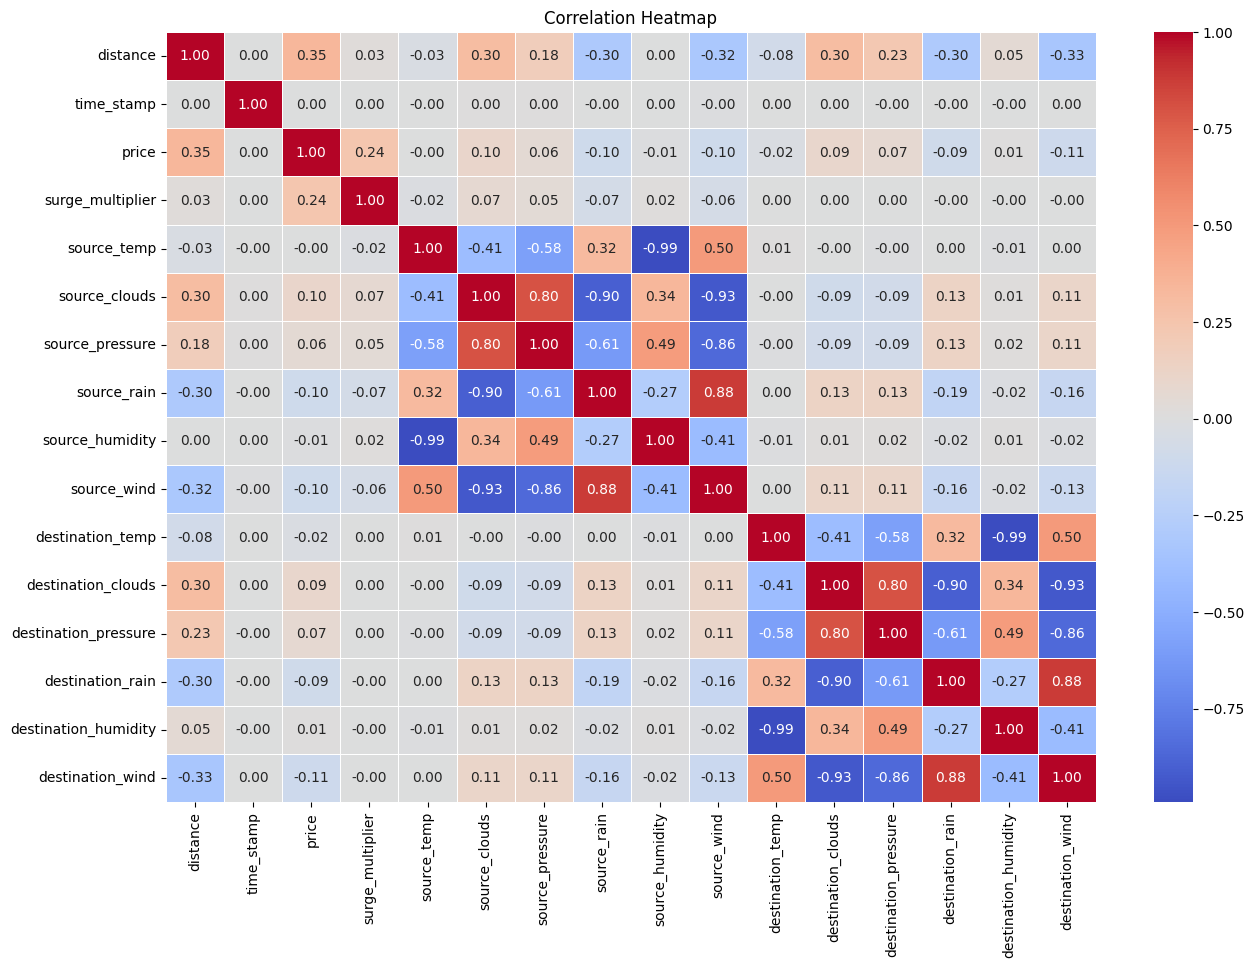

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate correlations for these numerical columns
correlations = numerical_data.corr()

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlations, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 4: Dataset Splitting

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

def label_encode(df, column):
    df = df.copy()
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df, le

In [17]:
def preprocess_inputs_label_encode(df):
    df = df.copy()
    
    # Drop unnecessary columns
    df = df.drop(['id', 'time_stamp', 'product_id'], axis=1)
    
    # Binary encode cab_type column
    df['cab_type'] = df['cab_type'].replace({'Lyft': 0, 'Uber': 1})
    
    # Label encode categorical columns and save the encoders
    label_encoders = {}  # Dictionary to store the encoders
    for column in ['destination', 'source', 'name']:
        df, encoder = label_encode(df, column)
        label_encoders[column] = encoder
        
    # Save the label encoders
    for column, encoder in label_encoders.items():
        joblib.dump(encoder, f"{column}_encoder.pkl")
    
    # Split df into X and y
    y = df['price']
    X = df.drop('price', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X and save the scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    # Save the scaler
    joblib.dump(scaler, "scaler.pkl")
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test

In [18]:
# Preprocessing and splitting the dataset into training and testing sets
print(data.columns)
X_train, X_test, y_train, y_test = preprocess_inputs_label_encode(data)

X_train.head(), y_train.head()

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'source_temp',
       'source_clouds', 'source_pressure', 'source_rain', 'source_humidity',
       'source_wind', 'destination_temp', 'destination_clouds',
       'destination_pressure', 'destination_rain', 'destination_humidity',
       'destination_wind'],
      dtype='object')


C:\Users\AG42415\AppData\Local\Temp\ipykernel_32704\988072429.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cab_type'] = df['cab_type'].replace({'Lyft': 0, 'Uber': 1})


(   distance  cab_type  destination    source  surge_multiplier      name  \
 0 -0.782551  0.965841     1.306884  1.015598         -0.158351  1.566330   
 1 -0.350616  0.965841    -1.302101  0.146002         -0.158351  0.993571   
 2  0.592589 -1.035367    -1.012213  1.595328         -0.158351 -0.438327   
 3  0.901114  0.965841     0.437222  0.725732         -0.158351  0.993571   
 4  0.239989  0.965841    -1.302101 -0.723594         -0.158351  0.993571   
 
    source_temp  source_clouds  source_pressure  source_rain  source_humidity  \
 0     2.075265      -0.286937        -1.161925     0.203658        -2.015513   
 1    -0.002167      -1.066915        -0.532527     0.901710         0.020939   
 2    -0.738175      -0.540430        -0.665848     0.929696         0.782908   
 3    -0.795154       0.551539        -0.166669    -1.788149         0.873618   
 4    -0.868506       2.130993         1.312262    -1.818534         0.782908   
 
    source_wind  destination_temp  destination_c

In [19]:
X_train.columns

Index(['distance', 'cab_type', 'destination', 'source', 'surge_multiplier',
       'name', 'source_temp', 'source_clouds', 'source_pressure',
       'source_rain', 'source_humidity', 'source_wind', 'destination_temp',
       'destination_clouds', 'destination_pressure', 'destination_rain',
       'destination_humidity', 'destination_wind'],
      dtype='object')

# 5: Model Training

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [21]:
# Predictions on the testing set
y_pred = rf_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [22]:
mae, mse, r2

(1.0227534778471623, 2.665625997800226, 0.9691769198168151)

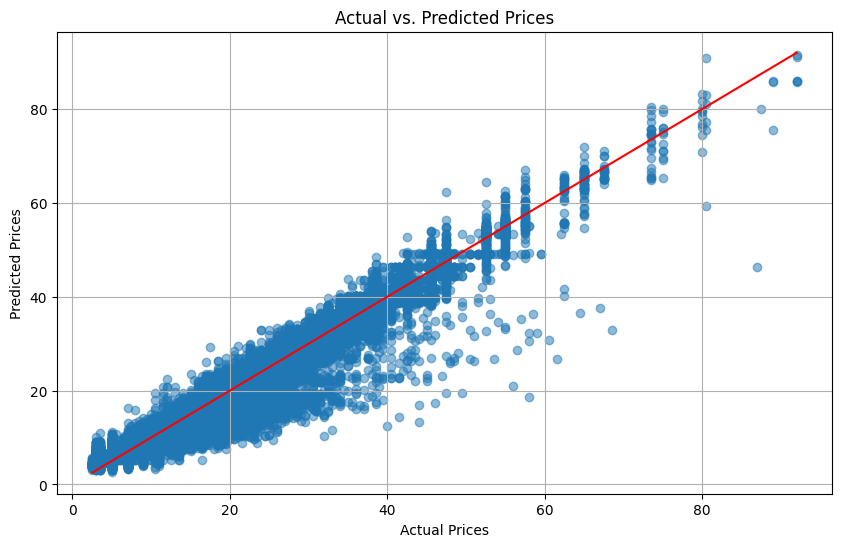

In [23]:
# Visualizing actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # y=x line
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()

In [24]:
# Displaying some sample predictions from the test set
sample_predictions = pd.DataFrame({
    'Actual Prices': y_test,
    'Predicted Prices': y_pred
}).reset_index(drop=True)

sample_predictions.head(10)

,Actual Prices,Predicted Prices
0,16.5,16.411083
1,10.5,10.017926
2,8.0,8.350624
3,3.5,3.914168
4,26.0,27.040263
5,16.5,16.500000
6,16.5,15.651030
7,10.5,8.897611
8,16.5,16.500000
9,17.5,17.030133


In [25]:
import numpy as np

# Generating random samples from the preprocessed dataset
np.random.seed(1)
random_indices = np.random.choice(X_test.index, size=10, replace=False)
random_samples = X_test.loc[random_indices]

In [26]:
# Predicting on the random samples
random_predictions = rf_model.predict(random_samples)

In [27]:
# Combining the samples and predictions into a DataFrame
random_samples_with_predictions = random_samples.copy()
random_samples_with_predictions['Predicted Price'] = random_predictions

random_samples_with_predictions

,distance,cab_type,destination,source,surge_multiplier,name,source_temp,source_clouds,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind,Predicted Price
51492,0.786519,-1.035367,-0.722326,1.305463,-0.158351,0.420812,-0.715515,-0.013945,-0.073655,0.401160,0.955258,0.574342,-0.869321,2.133228,1.311931,-1.819507,0.783687,-1.666342,7.749288
129080,0.610219,-1.035367,-1.012213,1.595328,-0.158351,0.134432,-0.738175,-0.540430,-0.665848,0.929696,0.782908,0.244114,-0.297758,1.489255,2.279388,-0.993513,-0.042425,-2.023527,16.558832
101239,-0.579806,-1.035367,-1.012213,-1.593189,-0.158351,0.134432,-0.061896,0.668535,0.425523,-0.601141,0.025475,-0.444998,-0.297758,1.489255,2.279388,-0.993513,-0.042425,-2.023527,12.043044
154505,0.539699,0.965841,-1.012213,1.595328,-0.158351,0.993571,-0.738175,-0.540430,-0.665848,0.929696,0.782908,0.244114,-0.297758,1.489255,2.279388,-0.993513,-0.042425,-2.023527,10.773517
163507,-0.350616,0.965841,-1.302101,0.146002,-0.158351,-1.297465,-0.002167,-1.066915,-0.532527,0.901710,0.020939,0.918199,-0.300904,0.025680,0.511918,0.176479,0.257154,0.136007,28.870312
9921,-0.861886,-1.035367,0.147335,0.435867,-0.158351,-0.438327,-0.382549,-0.793923,-0.386804,0.912105,0.374710,0.600900,-0.002276,-1.067123,-0.533061,0.902074,0.021122,0.918179,26.891052
55114,0.724814,0.965841,-1.012213,0.435867,-0.158351,0.707191,-0.382549,-0.793923,-0.386804,0.912105,0.374710,0.600900,-0.297758,1.489255,2.279388,-0.993513,-0.042425,-2.023527,10.130838
164605,0.848224,0.965841,-0.432439,0.725732,-0.158351,1.279951,-0.795154,0.551539,-0.166669,-1.788149,0.873618,-0.976858,2.191554,-1.067123,-1.525325,0.733675,-2.166712,1.044347,25.264333
165871,-0.368246,-1.035367,1.596771,1.015598,-0.158351,0.420812,2.075265,-0.286937,-1.161925,0.203658,-2.015513,0.842019,-0.738884,-0.540236,-0.666396,0.930074,0.783687,0.244001,6.884200
105872,-1.047001,-1.035367,0.147335,1.595328,-0.158351,-0.438327,-0.738175,-0.540430,-0.665848,0.929696,0.782908,0.244114,-0.002276,-1.067123,-0.533061,0.902074,0.021122,0.918179,26.492257


In [28]:
random_samples_with_predictions.columns

Index(['distance', 'cab_type', 'destination', 'source', 'surge_multiplier',
       'name', 'source_temp', 'source_clouds', 'source_pressure',
       'source_rain', 'source_humidity', 'source_wind', 'destination_temp',
       'destination_clouds', 'destination_pressure', 'destination_rain',
       'destination_humidity', 'destination_wind', 'Predicted Price'],
      dtype='object')

In [29]:
import joblib

# Define the path to save the model
model_path = 'model.pkl'

# Save the model to a file
joblib.dump(rf_model, model_path)

model_path

'model.pkl'

'unique_values.csv'